In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tnrange

In [2]:
class KArmedBanditEnv:
    def __init__(self, n_arms, q_start_init=1., q_stdev=1.):
        self.n_arms = n_arms
        self.q_start_init = q_start_init
        self.q_stdev = q_stdev
        self.reset()
    
    def reset(self, from_q_init=True):
        if from_q_init:
            self.q_stars = np.ones(self.n_arms)*self.q_start_init
        else:
            self.q_stars = np.random.normal(loc=0., scale=1., size=(self.n_arms,))
        
    def draw_reward(self, a):
        qa_mu = self.q_stars[a]
        return np.random.normal(qa_mu, self.q_stdev)
    
    def get_optimal_a(self):
        return np.argmax(self.q_stars)

    def apply_random_walk(self, mu=0, stdev=0.01):
        self.q_stars += np.random.normal(mu, stdev, self.q_stars.shape)

        
class Policy:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.reset()
        
    def reset(self):
        self.Qs = np.zeros(self.n_arms)
    
    def sample_action(self, t=None):
        raise NotImplementedError()
    
    def update_reward(self, a, r):
        raise NotImplementedError()

        
class EpsilonGreedyPolicy(Policy):
    def __init__(self, n_arms, epsilon):
        self.epsilon = epsilon
        super().__init__(n_arms)
        
    def reset(self):
        super().reset()
        self.Ns = np.zeros(self.n_arms)
    
    def sample_action(self, t=None):
        rand = np.random.rand()
        if rand >= self.epsilon: # exploit sample-average estimate
            a = np.argmax(self.Qs)
        else: # sample greedy action
            a = np.random.randint(0, self.n_arms)
        return a        
    
    def update_reward(self, a, r):
        self.Ns[a] += 1
        self.Qs[a] = self.Qs[a] + 1./(self.Ns[a])*(r-self.Qs[a])

        
class GreedyWithOptimisticInitPolicy(EpsilonGreedyPolicy):
    def __init__(self, n_arms, Q_zero, alpha=0.1):
        self.alpha = alpha
        self.Q_zero = Q_zero
        super().__init__(n_arms, epsilon=0)
    
    def reset(self):
        self.Qs = np.ones(self.n_arms) * self.Q_zero

    def update_reward(self, a, r):
        self.Qs[a] = self.Qs[a] + self.alpha*(r-self.Qs[a])

        
class UCBPolicy(EpsilonGreedyPolicy):
    def __init__(self, n_arms, c_gain):
        self.c_gain = c_gain
        super().__init__(n_arms, epsilon=0)
        
    def sample_action(self, t):
        as_unexplored = np.argwhere(self.Ns == 0)
        if len(as_unexplored) > 0:
            a = as_unexplored[0]
        else:
            UCBs = self.Qs + self.c_gain * np.sqrt(np.log(t)/self.Ns)
            a = np.argmax(UCBs)
        return a


class GradientBanditPolicy(Policy):
    def __init__(self, n_arms, alpha):
        self.alpha = alpha
        super().__init__(n_arms)
        
    def reset(self):
        super().reset()
        self.Hs = np.zeros(self.n_arms)
        self.R_avg_sum = 0.
        self.R_avg_count = 0

    def get_policy(self):
        pi = np.exp(self.Hs)
        pi /= np.sum(pi)
        return pi
        
    def update_R_avg(self, r):
        self.R_avg_sum += r
        self.R_avg_count += 1
        return self.R_avg_sum/self.R_avg_count
        
    def sample_action(self, t=None):
        pi = self.get_policy()
        rand = np.random.rand() # range: [0, 1)
        a = 0
        while rand >= 0:
            if rand < pi[a]:
                break
            else:
                rand -= pi[a]
                a += 1
        return a

    def update_reward(self, a, r):
        R_avg = self.update_R_avg(r)
        Hs_grad = -self.get_policy()
        Hs_grad[a] = 1 + Hs_grad[a]
        self.Hs = self.Hs + self.alpha * (r - R_avg) * Hs_grad


class Stats:
    def __init__(self, n_runs, n_steps, n_params):
        self.n_runs = n_runs
        self.n_steps = n_steps
        self.n_params = n_params
        self.reset()
        
    def reset(self):
        self.rewards = np.zeros((self.n_runs,self.n_steps, self.n_params))
        
    def update(self, run, step, param_idx, r):
        self.rewards[run, step, param_idx] = r
        
    def get_avg_rewards(self, step_start=100000):
        return np.mean(self.rewards[:, step_start:, :], axis=(0,1))


In [3]:
N_ARMS = 10
N_STEPS = 200000
N_RUNS = 20
W_RANDOM_WALK = True # set to false to generate Figure 2.6 from textbook

e_greedy_params = [1./128, 1./64, 1./32, 1./16, 1./8, 1./4]
grad_bdt_params = [1./32, 1./16, 1./8, 1./4, 1./2, 1, 2, 3]
ucb_params = [1./16, 1./8, 1./4, 1./2, 1, 2, 4]
opt_init_params = [1./4, 1./2., 1, 2, 4]

env = KArmedBanditEnv(n_arms=N_ARMS)
e_greedy_pis = [EpsilonGreedyPolicy(n_arms=N_ARMS, epsilon=e) for e in e_greedy_params]
grad_bdt_pis = [GradientBanditPolicy(n_arms=N_ARMS, alpha=a) for a in grad_bdt_params]
ucb_pis      = [UCBPolicy(n_arms=N_ARMS, c_gain=c) for c in ucb_params]
opt_init_pis = [GreedyWithOptimisticInitPolicy(n_arms=N_ARMS, Q_zero=q_zero) for q_zero in opt_init_params]
stats = [Stats(N_RUNS, N_STEPS, len(e_greedy_params)),
         Stats(N_RUNS, N_STEPS, len(grad_bdt_params)),
         Stats(N_RUNS, N_STEPS, len(ucb_params)),
         Stats(N_RUNS, N_STEPS, len(opt_init_params))]

def step_pis(run, step, env, pis, stats):
    for i in range(len(pis)):
        a = pis[i].sample_action(t=step+1)
        r = env.draw_reward(a)
        pis[i].update_reward(a, r)
        stats.update(run, step, i, r)
    
for run in tnrange(N_RUNS, desc='Run'):
    env.reset(from_q_init=W_RANDOM_WALK)
    for pi in e_greedy_pis: pi.reset()
    for pi in grad_bdt_pis: pi.reset()
    for pi in ucb_pis:      pi.reset()
    for pi in opt_init_pis: pi.reset()

    for step in tnrange(N_STEPS, desc='Step'):
        step_pis(run, step, env, e_greedy_pis, stats[0])
        step_pis(run, step, env, grad_bdt_pis, stats[1])
        step_pis(run, step, env, ucb_pis, stats[2])
        step_pis(run, step, env, opt_init_pis, stats[3])
        
        if W_RANDOM_WALK:
            env.apply_random_walk()


HBox(children=(IntProgress(value=0, description='Run: ', max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Step: ', max=200000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Step: ', max=200000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Step: ', max=200000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Step: ', max=200000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Step: ', max=200000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Step: ', max=200000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Step: ', max=200000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Step: ', max=200000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Step: ', max=200000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Step: ', max=200000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Step: ', max=200000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Step: ', max=200000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Step: ', max=200000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Step: ', max=200000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Step: ', max=200000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Step: ', max=200000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Step: ', max=200000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Step: ', max=200000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Step: ', max=200000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Step: ', max=200000), HTML(value='')))

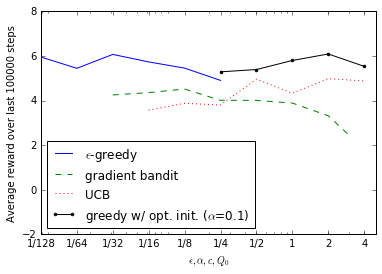

In [5]:
step_start = int(N_STEPS/2)
avgr_e_greedy = stats[0].get_avg_rewards(step_start=step_start)
avgr_grad_bdt = stats[1].get_avg_rewards(step_start=step_start)
avgr_ucb      = stats[2].get_avg_rewards(step_start=step_start)
avgr_opt_init = stats[3].get_avg_rewards(step_start=step_start)

fig = plt.figure()
plt.semilogx(e_greedy_params, avgr_e_greedy, 'b-', label=r'$\epsilon$-greedy')
plt.semilogx(grad_bdt_params, avgr_grad_bdt, 'g--', label='gradient bandit')
plt.semilogx(ucb_params,      avgr_ucb,      'r:', label='UCB')
plt.semilogx(opt_init_params, avgr_opt_init, 'k.-', label=r'greedy w/ opt. init. ($\alpha$=0.1)')
plt.xlabel(r'$\epsilon, \alpha, c, Q_0$')
plt.ylabel('Average reward over last %d steps' % (N_STEPS-step_start))
xmin, xmax = plt.gca().get_xlim()
ymin, ymax = plt.gca().get_ylim()
plt.axis([1./128, 4+1, min(ymin, -2), max(ymax, 8)])
plt.xticks([1./128, 1./64, 1./32, 1./16, 1./8, 1./4, 1./2, 1, 2, 4], ('1/128', '1/64', '1/32', '1/16', '1/8', '1/4', '1/2', '1', '2', '4'))
plt.legend(loc=3)
plt.show()